In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [2]:
feature_path = "./data/model_data/period_features"

def load_feature(num_period: int, feature_path: str = feature_path) -> pd.DataFrame:
    data = pd.read_parquet(f"{feature_path}/features_period_{num_period}.parquet")
    train_data = data.groupby("Stock").head(510).reset_index(drop=True)
    test_data = data.groupby("Stock").tail(250).reset_index(drop=True)
    print(f"Loaded {num_period} period data")
    print(f"Number of stocks: {data.Stock.nunique()}")
    print(f"Training days: {train_data.Date.nunique()}")
    print(f"Testing days: {test_data.Date.nunique()}")
    return train_data, test_data

In [3]:
train_data, test_data = load_feature(31)
train_data.head()

Loaded 31 period data
Number of stocks: 437
Training days: 510
Testing days: 250


,Date,Stock,Return_tomorrow,rtn_1,rtn_2,rtn_3,rtn_4,rtn_5,rtn_6,rtn_7,...,rtn_80,rtn_100,rtn_120,rtn_140,rtn_160,rtn_180,rtn_200,rtn_220,rtn_240,target
0,2020-12-21,A,-0.003481,-0.012741,-0.010003,0.004606,0.003322,0.008909,-0.005908,-0.008669,...,0.189457,0.227770,0.336738,0.301580,0.542229,0.583916,0.664735,0.416136,0.349605,1
1,2020-12-21,AAL,-0.038509,-0.024833,-0.041667,-0.045077,-0.053498,-0.035928,-0.055718,-0.105058,...,0.212349,0.440072,0.256831,0.358650,0.692955,0.694737,0.091525,-0.432699,-0.423971,0
2,2020-12-21,AAPL,0.028465,0.012395,-0.003652,0.003286,0.002737,0.052964,0.047545,0.040490,...,0.025758,0.333091,0.408695,0.577633,0.723753,0.954204,0.927039,0.602725,0.656558,1
3,2020-12-21,ABBV,-0.008774,-0.007085,-0.011250,-0.008888,0.008656,-0.004702,-0.024732,-0.035166,...,0.099788,0.079863,0.046096,0.141050,0.214830,0.369470,0.216254,0.123740,0.149651,0
4,2020-12-21,ABT,0.001758,-0.008076,-0.006343,0.006987,0.005956,0.012173,0.009998,0.014739,...,-0.028754,0.064611,0.179507,0.182604,0.161883,0.306539,0.403402,0.230113,0.250463,1


In [4]:
# 定义模型
model = xgb.XGBClassifier()

# 设置参数网格
param_grid = {
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 2, 3],
    'gamma': [0.1, 0.2, 0.3],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300]
}

# 设置网格搜索
grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=5, verbose=1)

# 加载你的数据
X_train = train_data.drop(columns=["Date", "Stock", "Return_tomorrow", "target"])
y_train = train_data["target"]
X_test = test_data.drop(columns=["Date", "Stock", "Return_tomorrow", "target"])
y_test = test_data["target"]

# 训练模型
grid_search.fit(X_train, y_train)

# 输出最优参数
print("Best parameters:", grid_search.best_params_)
print("Best accuracy:", grid_search.best_score_)


Fitting 5 folds for each of 2187 candidates, totalling 10935 fits


# xgboost classification

In [4]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
X_train = train_data.drop(columns=["Date", "Stock", "Return_tomorrow", "target"])
y_train = train_data["target"]
X_test = test_data.drop(columns=["Date", "Stock", "Return_tomorrow", "target"])
y_test = test_data["target"]

# grid search
param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.3]
}

model = xgb.XGBClassifier(objective="binary:logistic", random_state=27)

grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")

# train model
model = xgb.XGBClassifier(objective="binary:logistic", random_state=27, **grid_search.best_params_)
model.fit(X_train, y_train)

# predict
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

# evaluate
train_accuracy = accuracy_score(y_train, train_pred)
test_accuracy = accuracy_score(y_test, test_pred)
train_precision = precision_score(y_train, train_pred)
test_precision = precision_score(y_test, test_pred)
train_recall = recall_score(y_train, train_pred)
test_recall = recall_score(y_test, test_pred)
train_f1 = f1_score(y_train, train_pred)
test_f1 = f1_score(y_test, test_pred)

print(f"Train accuracy: {train_accuracy:.4f}, Test accuracy: {test_accuracy:.4f}")
print(f"Train precision: {train_precision:.4f}, Test precision: {test_precision:.4f}")
print(f"Train recall: {train_recall:.4f}, Test recall: {test_recall:.4f}")
print(f"Train f1: {train_f1:.4f}, Test f1: {test_f1:.4f}")

Best parameters: {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 200}
Train accuracy: 0.6496, Test accuracy: 0.5011
Train precision: 0.6483, Test precision: 0.5000
Train recall: 0.6505, Test recall: 0.4897
Train f1: 0.6494, Test f1: 0.4948


In [5]:
test_pred_prob = model.predict_proba(X_test)[:, 1]
test_pred_prob

array([0.5172325 , 0.41996813, 0.5573828 , ..., 0.2843535 , 0.68669915,
       0.5138011 ], dtype=float32)

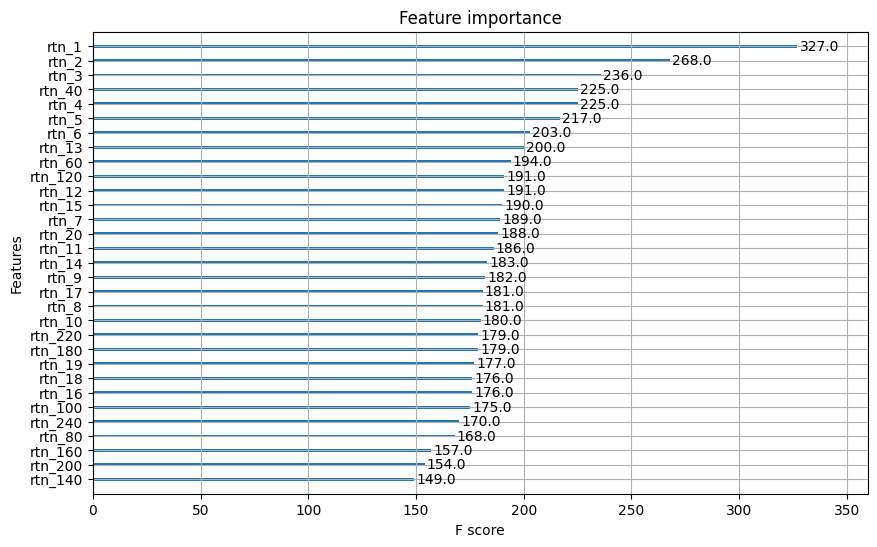

In [7]:
# plot feature importance
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, ax=plt.gca())
plt.show()

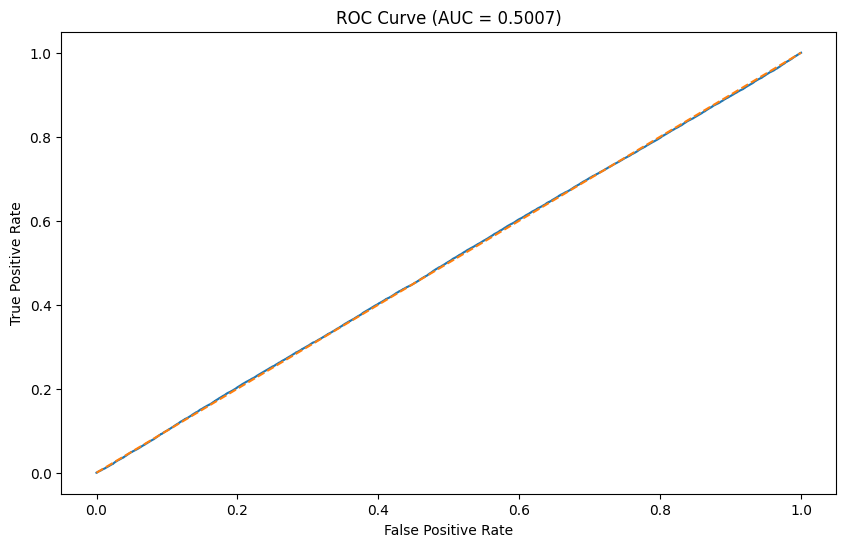

In [8]:
# plot ROC curve
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, _ = roc_curve(y_test, test_pred_prob)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], "--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (AUC = {roc_auc_score(y_test, test_pred_prob):.4f})")
plt.show()

In [6]:
# AUC
from sklearn.metrics import roc_auc_score
roc_auc = roc_auc_score(y_test, test_pred_prob)
roc_auc

0.5006887844406636

In [9]:
result_df = test_data[["Date", "Stock", "Return_tomorrow", "target"]].copy()
result_df["pred"] = test_pred
result_df["pred_prob"] = test_pred_prob
result_df.head()

,Date,Stock,Return_tomorrow,target,pred,pred_prob
0,2022-12-30,A,0.002606,1,1,0.517232
1,2022-12-30,AAL,0.001572,1,0,0.419968
2,2022-12-30,AAPL,-0.037405,0,1,0.557383
3,2022-12-30,ABBV,0.004765,1,1,0.551870
4,2022-12-30,ABT,-0.001913,0,0,0.496987


In [11]:
result_df["top10"] = result_df.groupby("Date")["pred_prob"].transform(lambda x: (x >= x.quantile(0.9)) | (x <= x.quantile(0.1)))
sub_result_df = result_df[result_df["top10"]].copy()
accuracy_score(sub_result_df["target"], sub_result_df["pred"])

0.4980909090909091

In [7]:
# save
result_df.to_parquet("./result/xgboost/xgboost_period_31.parquet")
model.save_model(r"data\model_data\models\xgboost\xgboost_period_31.json")